In [1]:
from gc import callbacks
import os



from model import *

In [2]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    """
    # Make a list for images and masks filenames
    bright_img = []
    fluor_img = []
    
    r = re.compile(r'r(\d+)c(\d+)f(\d+)p(\d+)-ch(\d+)sk(\d+)')
    def custom_key(x):
        val = int(r.search(x).group(5)) * 100_000_000 + int(r.search(x).group(1)) * 10_000_000 + int(r.search(x).group(2)) * 100_000 + int(r.search(x).group(3)) * 1_000 + int(r.search(x).group(6))
        return val
    def custom_key2(x):
        val = int(r.search(x).group(1)) * 1_000_000 + int(r.search(x).group(2)) * 100_000 + int(r.search(x).group(3)) * 1_000 + int(r.search(x).group(6))
        return val
    # Read the images folder like a list
    for filename in sorted(glob.glob(path1 + '*.tiff'), key = lambda x: custom_key(x)):
        #print (filename)
        #if (int(r.search(filename).group(2))) < 6:
            #continue
        
        #if (int(r.search(filename).group(2))) == 6:
            #if (int(r.search(filename).group(1))) < 6:
               # continue
        #if (int(r.search(filename).group(2))) == 11:
            #if (int(r.search(filename).group(1))) > 3:
               # continue
            
        if (int(r.search(filename).group(5)) == 1):
            bright_img.append(filename)
        elif (int(r.search(filename).group(5)) == 2):
            fluor_img.append(filename)
    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    bright_img.sort(key = lambda x: custom_key2(x))
    fluor_img.sort(key = lambda x: custom_key2(x))
    
    return bright_img, fluor_img

In [4]:
def PreprocessData(bright, fluor, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    
    
     image_bright_field  = imread(filename)
            image_bright_field = np.float64(image_bright_field)
            image_bright_field = image_bright_field * 255.0 / image_bright_field.max()
            image_bright_field = np.uint8(image_bright_field)
            
            image_fluor  = imread(filename)
            image_fluor = np.float64(image_fluor)
            image_fluor = image_fluor * 255.0 / image_fluor.max()
            image_fluor = np.uint8(image_fluor)
    """
    # Pull the relevant dimensions for image and mask
    m = len(bright)                     # number of images
    i_h, i_w, i_c = target_shape_img   # pull height, width, and channels of image
    m_h, m_w, m_c = target_shape_mask  # pull height, width, and channels of mask
    print (i_h, i_w, i_c)
    print (m_h, m_w, m_c)
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
    # Resize images and masks
    for file in bright:
        # convert image into an array of desired shape (3 channels)
        index = bright.index(file)
        #path = os.path.join(path1, file)
        
        #image_bright_field = Image.open(file)#.convert('RGB') #imread(file) #Image.open(file).convert('RGB')
        image_bright_field = imread(file)
        image_bright_field = resize(image_bright_field, (i_h, i_w),
                       anti_aliasing=True)
        #print (image_bright_field.shape)
        #image_bright_field = image_bright_field.resize((i_h, i_w))
        image_bright_field = np.reshape(image_bright_field,(i_h, i_w, i_c)) 
        #image_bright_field = single_img/256.
        image_bright_field = np.float64(image_bright_field)
        image_bright_field = image_bright_field / image_bright_field.max()
        #image_bright_field = np.uint8(image_bright_field)
        X[index] = image_bright_field
        #print (image_bright_field.shape)
        
        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = fluor[index]
        #image_fluor  = Image.open(file) # imread(single_mask_ind)
        image_fluor  = imread(single_mask_ind)
        
        ###new
        labels, _ = model.predict_instances(normalize(image_fluor))
        img_cont = find_boundaries(labels)
        labels = np.where(img_cont != 0, 0, labels)
        labels = np.where(labels != 0, 1, labels)
        labels = resize(labels, (i_h, i_w),
                       anti_aliasing=True)
        #image_fluor = image_fluor.resize((i_h, i_w))
        labels = np.reshape(labels,(i_h, i_w, i_c)) 
        labels = np.where(labels != 0, 1, labels)
        labels = np.uint8(labels)
        #image_bright_field = single_img/256.
        y[index] = labels
        # image_fluor = resize(image_fluor, (i_h, i_w),
        #                anti_aliasing=True)
        # #image_fluor = image_fluor.resize((i_h, i_w))
        # image_fluor = np.reshape(image_fluor,(i_h, i_w, i_c)) 
        # image_fluor = np.float64(image_fluor)
        # image_fluor = image_fluor * 31.0 / image_fluor.max()
        # image_fluor = np.uint8(image_fluor)
        # #image_bright_field = single_img/256.
        # y[index] = image_fluor
        
    return X, y

In [5]:

# Call the apt function
path1 = '/media/nk/My Passport/experiments/JW167_BF_Hoechst/Images/'
path2 = '/media/nk/My Passport/experiments/JW167_BF_Hoechst/Images/'

bright, fluor = LoadData (path1, path2)


In [6]:
print ('Count of Bright field imaged:', len(fluor))
print ('Count of FLuor imaged:',  len(bright))

Count of Bright field imaged: 350
Count of FLuor imaged: 350


/media/nk/My Passport/experiments/JW167_BF_Hoechst/Images/r03c04f01p01-ch1sk1fk1fl1.tiff
/media/nk/My Passport/experiments/JW167_BF_Hoechst/Images/r03c04f01p01-ch2sk1fk1fl1.tiff
(1080, 1080)
(1080, 1080)


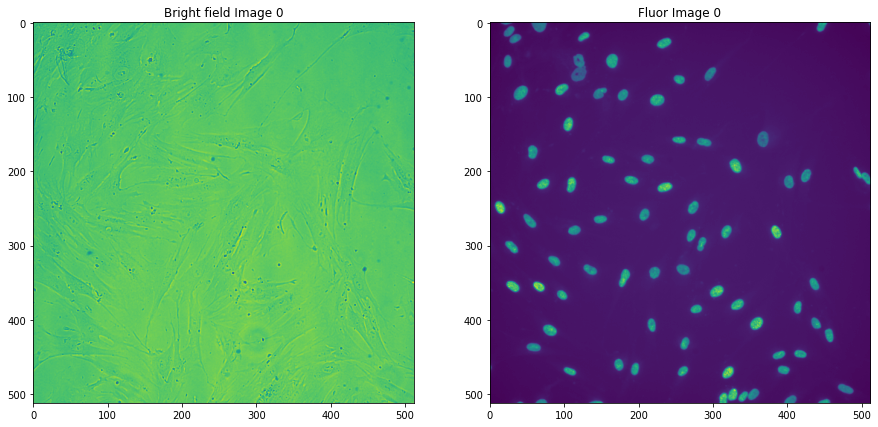

In [7]:
# View an example of image and corresponding mask 
show_images = 1
print(bright[200])
print(fluor[200])
for i in range(show_images):
    img_view  = imread(bright[200])
    mask_view = imread(fluor[200])
    image_resized = resize(img_view, (512, 512),
                       anti_aliasing=True)
    mask_resized = resize(mask_view, (512, 512),
                       anti_aliasing=True)
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(image_resized)
    arr[0].set_title('Bright field Image '+ str(i))
    arr[1].imshow(mask_resized)
    arr[1].set_title('Fluor Image '+ str(i))

512 512 1
512 512 1
Found model '2D_versatile_fluo' for 'StarDist2D'.


2022-04-14 11:07:18.655251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 11:07:18.656749: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
X Shape: (350, 512, 512, 1)
Y shape: (350, 512, 512, 1)


Text(0.5, 1.0, 'Processed Masked Image ')

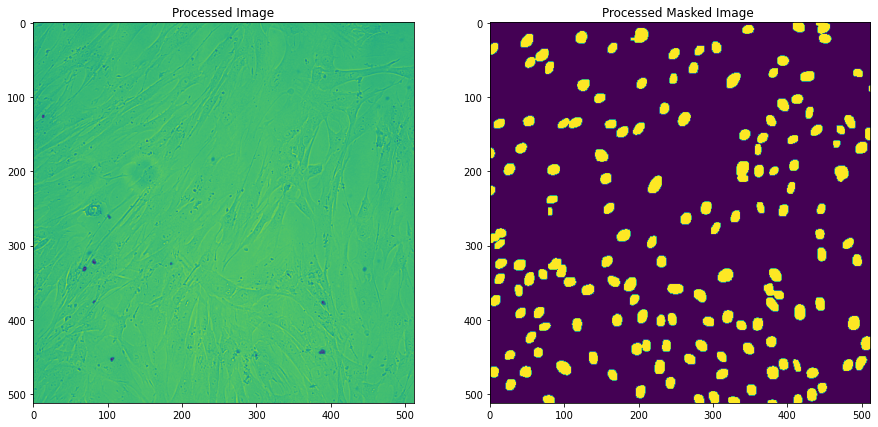

In [8]:
# Define the desired shape
target_shape_img = [512,512, 1]
target_shape_mask = [512, 512, 1]

# Process data using apt helper function
X, y = PreprocessData(bright, fluor, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
#print(np.unique(y))


# Visualize the output
image_index = 200
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

1


Text(0.5, 1.0, 'Processed Masked Image ')

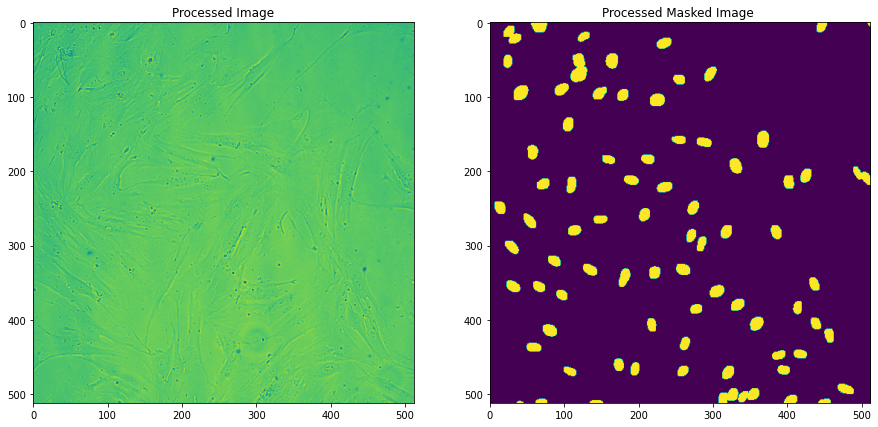

In [9]:
image_index = 200
print (np.max(y[image_index]))
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index])
arr[1].set_title('Processed Masked Image ')

In [22]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 123)

In [23]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(512,512,1), n_filters=64, n_classes=2)

In [24]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_22[0][0]']              
                                )                                                           

 conv2d_35 (Conv2D)             (None, 128, 128, 25  590080      ['conv2d_34[0][0]']              
                                6)                                                                
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 256, 256, 12  295040     ['conv2d_35[0][0]']              
 spose)                         8)                                                                
                                                                                                  
 concatenate_9 (Concatenate)    (None, 256, 256, 25  0           ['conv2d_transpose_6[0][0]',     
                                6)                                'batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_36 (Conv2D)             (None, 256, 256, 12  295040      ['concatenate_9[0][0]']          
          

In [25]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

batch_size = 8

In [27]:
results = unet.fit(X_train, y_train, batch_size=batch_size, epochs = 1, validation_data=(X_valid, y_valid))

35/35 [==============================] - 774s 22s/step - loss: 0.4011 - accuracy: 0.9003 - val_loss: 0.2468 - val_accuracy: 0.9327


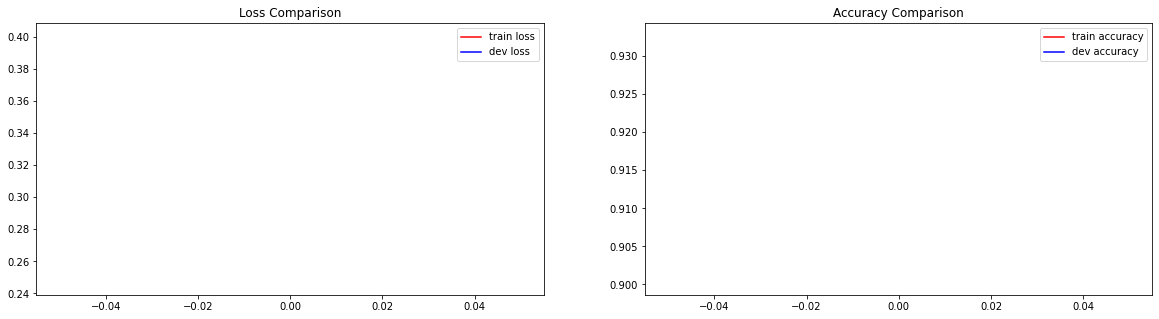

In [28]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [18]:
unet.save('my_model_BJ.h5')

In [29]:
unet.evaluate(X_valid, y_valid)

3/3 [==============================] - 37s 10s/step - loss: 0.2468 - accuracy: 0.9327


[0.24680347740650177, 0.9327268600463867]

In [30]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(35, 35))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')
    plt.savefig('plot{}.png'.format(index))



In [ ]:
# Add any index to contrast the predicted mask with actual mask
for i in range (len(X_valid)):
    if i >50:
        break
    VisualizeResults(i) 

3869604934.py (8): More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
